# User Tracking and Document Modeling with nested CRF

In [1]:
##多項分布の乱数を生成する関数
def rmnom(pr, n, k, pattern):
    if pattern==1:
        z_id = np.array(np.argmax(np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis], axis=1), dtype="int")
        Z = np.diag(np.repeat(1, k))[z_id, ]
        return z_id, Z
    z_id = np.argmax((np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis]), axis=1)
    return z_id

In [2]:
#####User Tracking and Document Modeling with nCRF#####
# ライブラリの読み込み
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
import scipy
from scipy import stats
from scipy import special
from scipy import sparse
from pandas.tools.plotting import scatter_matrix
from numpy.random import *

np.random.seed(98537)

# 1. 無限次元のディリクレ分布
## a. ノンパラメトリックベイズモデル
ノンパラメトリックベイズモデルの中心的な役割を果たすのは**ディレクリ過程混合モデル**です。このモデルは有限混合モデルを**無限混合モデル**に拡張したものとみなすことができます。
まず有限混合モデルについてはあらかじめ決められたクラス数$K$に分割するようなクラスタリングの確率モデルの1つです。  
モデルの事後分布は

\begin{equation}
p(\bf z\rm_{1:n},\bf \theta\rm_{1:K} | \bf x\rm_{1:n}) \propto \prod_{i=1}^{n} p(\bf x\rm_{i}|\bf \theta_{z_\rm{i}}) \rm p(\bf z\rm_{i}|\bf \pi\rm_{0}) \prod_{k=1}^{K}p(\bf \theta\rm_{k}|\alpha_{0}) \tag{1}
\end{equation}

となります。$n$はレコード数、$K$はクラス数を表します。
対して、無限混合モデルはクラス数$K$を$\infty$次元に拡張して

\begin{equation}
p(\bf z\rm_{1:n},\bf \theta\rm_{1:\infty} | \bf x\rm_{1:n}) \propto \prod_{i=1}^{n} p(\bf x\rm_{i}|\bf \theta_{z_\rm{i}}) \rm p(\bf z\rm_{i}|\bf \pi\rm_{0}) \prod_{k=1}^{\infty}p(\bf \theta\rm_{\infty}|\alpha_{0}) \tag{2}
\end{equation}

となります。このモデルの利点は有限混合モデルと異なり、あらかじめクラス数を決めなくて良いという利点がありデータからクラス数をデータから推定することができます。  
クラス数を$k$次元から$\infty$次元に拡張するときのクラスタリングは**中華料理店過程(Chinese Restaurant Process)** で定式化することができます。
## b. 中華料理店過程
### i. 概要と定式化
中華料理店過程は無限混合モデルのディリクレ分布の無限次元を定式化するための方法です。  
ディリクレ分布のパラメータは次元数が有限の場合$\sum_{j=1}^{k}\pi_{j}=1$が満たされます。これを無限次元に拡張しても$\sum_{j=1}^{\infty}\pi_{j}=1$が満たされなければいけません。しかし無限次元の$\pi$は扱いが難しいので、これを周辺化して

\begin{equation}
p(\bf z\rm_{i}=k | \bf z\rm_{1:n}^{\backslash i},\bf\pi\rm_{0}) = \frac{n_{k}^{\backslash i} + \alpha/K}{n-1+\alpha} \tag{3}
\end{equation}

とします。ただし$n_{k}^{\backslash i}$はクラス$k$に割り当てられたレコードiを取り除いた頻度、$K$はクラス数、$\alpha$はディリクレ事前分布のパラメータ(ディリクレ過程の文脈では集中度パラメータ)を表します。  
もし、$k$が$1:K$の集合にない場合の(3)は以下の式で表されます。

\begin{equation}
p(\bf z\rm_{i}=K+1 | \bf z\rm_{1:n}^{\backslash i},\bf\pi\rm_{0}) = \frac{\alpha/K}{n-1+\alpha} \tag{4}
\end{equation}

これは$1:K$を既存クラスと考えると$K+1$は新しいクラスと解釈できます。  
$\bf z\rm_{1:n}^{\backslash i}$に現れる$\{1,2,\cdots,K\}$の集合を$K^{+}\bf(z\rm_{1:n}^{\backslash i})$と表現したとき新しいクラス$k\not\in K^{+}\bf(z\rm_{1:n}^{\backslash i})$が選択される確率は(4)から

\begin{equation}
p(z_{i} \not\in K^{+}\bf(z\rm_{1:n}^{\backslash i})|\bf z\rm_{1:n}^{\backslash i}) = \bigl(1 - \frac{|K^{+}(\bf z\rm_{1:n}^{\backslash i})|}{K}\bigr)\frac{\alpha}{n-1+\alpha} \tag{5}
\end{equation}

となり、さらに$K$を$\infty$とすると既存クラスの選択確率と新しいクラスの選択確率の事前分布は

\begin{equation}  
y_{i} =
  \begin{cases}
      p(z_{i} \in K^{+}\bf(z\rm_{1:n}^{\backslash i})|\bf z\rm_{1:n}^{\backslash i}) = \frac{n_{k}^{\backslash i}}{n-1+\alpha} \\
      p(z_{i} \not\in K^{+}\bf(z\rm_{1:n}^{\backslash i})|\bf z\rm_{1:n}^{\backslash i}) = \frac{\alpha}{n-1+\alpha} \tag{6}
  \end{cases}
\end{equation}

となり、(6)の定式化を中華料理店過程と言います。

結局、(6)より$z_{i}$のサンプリング確率は

\begin{equation}  
p(z_{i}=k|\bf x\rm_{1:n},\bf z\rm_{1:n}^{\backslash i}) =
  \begin{cases}
      p(\bf x\rm_{i}|\bf \theta_{z_\rm{i}})\frac{n_{k}^{\backslash i}}{n-1+\alpha}& \quad \text{if } k\in K^{+}(z_{1:n}^{\backslash i}) \\
      p(\bf x\rm_{i}|\bf \theta_{z_\rm{i}})\frac{\alpha}{n-1+\alpha} \tag{7}
  \end{cases}
\end{equation}

となります。
  
**中華料理店過程の模式図**
![title](https://www.researchgate.net/profile/Timothy_Odonnell/publication/38005164/figure/fig2/AS:293881708724225@1447078267743/A-series-of-possible-distributions-generated-by-the-Chinese-restaurant-process-Shown-is.png)

### ⅲ. ディリクレ過程
1.のchinese restaurant processの背後には**ディリクレ過程**と呼ばれる確率過程が存在します。これを
\begin{equation}
    G \sim DP\bigl(\alpha, H_{0}(\bf \theta \rm|\eta)\bigr) \tag{8}
\end{equation}
と表現します。この式の$\alpha$を集中度パラメータ、$H_{0}(\bf \theta|\rm \eta)$を基底分布と呼び、この基底分布は無限次元の離散分布になっています。
これは$\theta$の生成過程として定義でき、基底分布と集中度パラメータに応じて$\theta$が生成されます。このディリクレ過程の構成方法の1つとして前述した中華料理店過程があります。
他にも、棒折り過程と呼ばれる方法でディリクレ過程を構成することもできます。

In [45]:
a = np.repeat(100, 3)
np.round(np.random.dirichlet(a, 1).reshape(-1), 3)

array([0.346, 0.32 , 0.334])

# 2. Nested and Franchise
## a. Chinese Restaurant Franchise Process
### i. 階層ディリクレ過程
前述したディリクレ過程では1人のユーザーに対して、1つのトピックしか生成できませんので、Latent Dirichlet Allocation(LDA)のように1人のユーザーに複数のトピックを持つようなモデルでは対応することができません。
そこでディリクレ過程を階層化した**階層ディリクレ過程**を用いることで対応することができます。階層ディリクレ過程の生成過程は以下の通りです。
\begin{equation}
    G_{0} \sim DP(\alpha, H) \\
    G_{i} \sim DP(\alpha^{\prime}, G_{0}) \tag{9}
\end{equation}
(9)の意味するところは$G_{0}$をディリクレ過程から生成し、さらに$G_{0}$からユーザー単位でディリクレ過程を生成することでLDAのような1人が複数のトピックを持つ状況に対応しています。

### ⅱ. 中華料理店フランチャイズ過程
階層ディリクレ過程は**中華料理店フランチャイズ過程**で構成することができます。
中華料理店フランチャイズ過程は以下の3つの事前分布でトピックを生成します。
- ユーザーごとの既存のトピックを生成する確率
- ユーザーごとの新しいトピックを生成する確率(他のユーザーでは同じトピックが生成済み)
- ユーザー全体の全く新しいトピックを生成する確率  

これらの事前確率はユーザーごとのパラメータとグローバルのパラメータが階層的に共有されています。  
この3つの事前分布を数式として書き下すと以下のようになります。
\begin{equation}  
p(z_{dn}=k|\bf x, \rm \alpha,\beta) \sim
  \begin{cases}
      \frac{n_{k}^{d}}{n^{d}+\alpha} + \frac{\alpha}{n^{d}+\alpha}\frac{n_{k}}{n + \beta} \quad \text{if ユーザーの既存トピック} \\
      \frac{\alpha}{n^{d}+\alpha}\frac{n_{k}}{n + \beta} \quad \text{if ユーザーの新トピック} \\
      \frac{\alpha}{n^{d}+\alpha}\frac{\beta}{n + \beta} \quad \text{if 全体の新トピック} \\ \tag{10}
  \end{cases}
\end{equation}

なお、$k$はトピック、$n$はグローバルのレコード数、$n^{u}$はユーザーuのレコード数、$\alpha$はユーザ単位の集中度パラメータ、$\beta$はグローバルでの集中度パラメータになります。
(10)を見ると、ユーザーのパラメータとグローバルのパラメータが共有されている事がわかり、階層モデルを構成していることが確認できます。  
また、「ユーザーの既存トピック」 > 「ユーザーの新トピック」 > 「全体の新トピック」の順で事前確率が高いです。

**中華料理店フランチャイズ過程の模式図**
![title](https://www.researchgate.net/publication/221404031/figure/fig1/AS:340512163811332@1458195834587/The-recurrent-Chinese-restaurant-franchise-RCRF-precoces-The-figure-shows-a.png)



## b. Latent Dirichlet Allocation(LDA)について
### ⅰ. LDAを用いるモチベーション
トピック分析に用いる手法として、一般的なクラスタリング法であるk-means法や混合多項分布モデルなどが用いられますが、これらの手法は1人のユーザーが1つだけのトピックを持つと仮定しています。しかし、1人のユーザーは様々なトピックに基づいて行動を行います。例えば買い物行動を例に取ると食品や衣料品やアウトドア用品を買ったりなど1人のユーザーが様々な行動を取ります。この場合1人のユーザーが1つのトピックを持つと仮定した場合「食品×衣料品」や「衣料品×アウトドア用品」などの組み合わせトピックを用意する必要があります。仮に食品や衣料品などを独立したトピックとしたとき、独立したトピックが10個あれば、55個のトピックを用意する必要があります。  
しかし、LDAは1人につき1つだけトピックを持つという仮定を緩和してユーザーが複数のトピックを持つことを許したモデルです。トピックモデルはユーザーごとにトピック分布$\bf \theta_{d}\rm =(\theta_{d1},\theta_{d2},\cdots,\theta_{dk})$を持つことで少ないトピックでユーザの多様な行動を表現することができます。

### ⅱ. LDAのベイズ的生成過程
LDAはベイズモデルの一種であり、パラメータに対してディリクレ事前分布を持ちます。パラメータは主に2つ存在し、前述したユーザーに対するトピック分布と場所に対するそれぞれのトピック$k$に関する場所分布です。LDAのベイズ的な生成過程は以下のようになります。

#### LDAの生成過程
- For トピック $k=1,\cdots,K$  
    (a) 場所分布を生成 $\phi_{k} \sim Dirichlet(\beta)$  
  
  
- For ユーザー $d=1,\cdots,D$  
    (a) トピック分布を生成 $\theta_{d} \sim Dirichlet(\alpha)$    
    - For 場所 $n=1,\cdots,N_{d}$  
    (a) トピックを生成 $z_{dn} \sim Categorical(\theta_{d})$  
    (b) 場所を生成 $w_{dn} \sim Categorical(\phi_{z_{dn}})$  
  
この生成過程はユーザーのトピック分布からトピックを生成され、生成されたトピックに応じて行く場所を決定するというモデルになります。なおLDAの基本的なモデルは場所の行った順番は考慮していないことに考慮してください。(順番も考慮するモデルもあります。)  
LDAの概念図は以下の画像を参照してください。(もともと自然言語処理のために開発された経緯があるので、例が自然言語処理です。)
![title](https://blog.albert2005.co.jp/wp-content/uploads/2015/09/topic_v2.png)

また、パラメータに対して事前分布を置かないモデルも存在し、確率的潜在的意味解析(PLSA)と呼ばれます。

### ⅲ. LDAのグラフィカルモデル
LDAのグラフィカルモデルは以下のようになります。
![title](http://drive.google.com/uc?export=download&id=1uPP6u_qeke685hy05VOJSV_bvAiBFqsH)




## c. Nested Chinese Restaulant Franchise model
### i. トピックの階層化
通常、Latent Dirichlet Allocationは並列的にトピックが構成されており、通常トピック間に相関を考慮していません。しかし、あるトピックが他のトピックに似ているという仮定をモデルに加えたい場合もあるでしょう。トピック間の相関を組み込む方法は複数ありますが、ここでは階層的にトピックを構成することにします。
階層化したトピックは以下のようになります。

![title](https://ai2-s2-public.s3.amazonaws.com/figures/2017-08-08/2f14e3b459dc78868851c372ae00a74519c3e1f4/7-Figure2-1.png)


### ⅱ. 入れ子型中華料理店フランチャイズ過程
階層的にトピックを構成する際のモデル化として事前にトピックを決め打ちすることもできますが、1階層目はともかく2階層目は1階層目のトピック1つ1つに対してトピック数を決めなければならず、人手で決め打ちするのは困難になってきます。さらに深い階層が必要であればなおさらです。
この問題に対して、階層構造を生成する確率過程として**nested Chinese Restaulant Process**と呼ばれるモデルがあります。これは名前の通り中華料理店過程を拡張したものです。このモデルはユーザーがトピックを持つとは仮定せず、**ユーザーが1つのノードパスを持つ**ことを仮定してモデルを構成することで階層的にトピックを構成することができます。  
しかし、このnested Chinese Restaulant Processでは中華料理店過程と同じように1人のユーザーが1つのノードしか持つことができません。そこでnested Chinese Restaulant ProcessとChinese Restaulant Franchiseを組み合わせることで新たな確率モデルである**nested Chinese Restaulant Franchise**を構成します。  

### ⅲ. 事前分布の構成
nested Chinese Restaulant Franchiseは親ノード$v$から子ノード$w$が生成される確率を事前確率として定式化します。
#### 1階層目から2階層目へのノードの生成
親ノードを$v_{1}$、子ノードを$w_{1, k}$として
\begin{equation}  
p(v_{1} \to w_{1, k}) \sim
  \begin{cases}
      \frac{n_{w_{1, k}}^{d}}{n^{d}+\alpha} + \frac{\alpha}{n^{d}+\alpha}\frac{n_{w_{1, k}}}{n + \beta} \quad \text{if ユーザーの既存ノード} \\
      \frac{\alpha}{n^{d}+\alpha}\frac{n_{w_{1, k}}}{n + \beta} \quad \text{if ユーザーの新ノード} \\
      \frac{\alpha}{n^{d}+\alpha}\frac{\beta}{n + \beta} \quad \text{if 全体の新ノード} \\ \tag{10}
  \end{cases}
\end{equation}  

となります。1階層目が1つのノードしか持たないためChinese Restaulant Franchiseと同じ構成となります。

#### 2階層目から3階層目へのノードの生成
上記で生成した子ノード$w_{1, k}$を親ノード$v_{2, k}$とし、その子ノードを$w_{2, k^{\prime}}$とし、

\begin{equation}  
p(v_{2, k} \to w_{2, k^{\prime}}) \sim
  \begin{cases}
      \frac{n_{vw}^{d}}{n_{v}^{d}+\alpha} + \frac{\alpha}{n_{v}^{d}+\alpha}\frac{n_{vw}}{n_{v} + \beta} \quad \text{if } w \in C^{d}(v) \\
      \frac{\alpha}{n_{v}^{d}+\alpha}\frac{n_{vw}}{n_{v} + \beta} \quad \text{if } w \not\in C^{d}(v) \text{ and } w \in C(v) \\
      \frac{\alpha}{n_{v}^{d}+\alpha}\frac{\beta}{n_{v} + \beta} \quad \text{if } w \not\in C(v) \\ \tag{11}
  \end{cases}
\end{equation}  

となります(ノードの添字は省略)。この事前分布を用いることで2階層目の特定の親ノードから子ノードをユーザーごとに生成していくことが可能となります。
この事前分布に尤度関数の積を取ると階層構造のある任意のノンパラメトリックベイズな統計・機械学習モデルを作成することができます。

**nested Chinese Restaulant Franchiseの模式図**
    ![title](https://yahoo.jp/box/-P_grR)

In [3]:
####データの生成####
##データの設定
geo = 2
levels = 2
k1 = 5
k2 = np.array([4, 4, 5, 5, 6])
topic = 15
hh = 4000
v = 1000   #語彙数
Lambda = np.random.gamma(12.5, 1/0.25, hh)
pt = np.random.poisson(Lambda, hh); pt[pt < 10] = 10
pt_vec = pt[:, np.newaxis]
N = np.sum(pt)
w = np.random.poisson(np.random.gamma(10.0, 1/0.5, N)); w[w < 5] = 5
f = np.sum(w)

In [4]:
##IDとインデックスを作成
#IDを作成
u_id = np.repeat(np.arange(hh), pt)
d_id = np.repeat(np.arange(N), w)

#インデックスを作成
u_list = [i for i in range(hh)]
d_list = [i for i in range(N)]
d_vec = [i for i in range(N)]
for i in range(hh):
    u_list[i] = np.array(np.where(u_id==i)[0], dtype="int")
for i in range(N):
    d_list[i] = np.array(np.where(d_id==i)[0], dtype="int")
    d_vec[i] = np.repeat(1, d_list[i].shape[0])

In [5]:
####パラメータとデータの生成####
rp = 0
while True:
    rp = rp + 1
    print(rp)
    
    ##ノード分布を生成
    #グローバルノード分布を生成
    G1 = np.random.dirichlet(np.repeat(3.0, k1), 1).reshape(-1)
    G2 = [np.random.dirichlet(np.repeat(2.5, k2[j]), 1).reshape(-1)  for j in range(k1)]
    GT1 = G1.copy(); GT2 = G2.copy()

    #ローカルノード分布を生成
    alpha1 = 2.0
    theta1 = np.random.dirichlet(alpha1*G1, hh)
    theta2 = [np.random.dirichlet(alpha1*G2[j], hh) for j in range(k1)]
    thetat1 = theta1.copy(); thetat2 = theta2.copy()

    
    ##モデルパラメータを生成
    #トピック分布を生成
    er = 0.01
    alpha2 = 2.5
    gamma_global = np.zeros((k1, topic))
    gamma = [j for j in range(k1)]
    for j in range(k1):
        gamma_global[j, ] = np.random.dirichlet(np.repeat(0.3, topic), 1)
        gamma[j] = np.random.dirichlet(alpha2*gamma_global[j, ]+er, k2[j])
    gammat_global = gamma_global.copy()
    gammat = gamma.copy()

    #location分布を生成
    min_point = -7.5; max_point = 7.5
    target_range = np.array([-2.75, 2.75])
    longitude = np.array([min_point, max_point]); latitude = np.array([min_point, max_point])
    mu_global = np.append(np.random.uniform(longitude[0], longitude[1], k1), 
                          np.random.uniform(latitude[0], latitude[1], k1)).reshape(k1, geo, order="F")
    mu = [i for i in range(k1)]
    Cov = [i for i in range(k1)]
    for i in range(k1):
        mu0 = np.zeros((k2[i], geo))
        Cov0 = np.zeros((geo, geo, k2[i]))
        for j in range(k2[i]):
            mu0[j, ] = mu_global[i, ] + np.random.uniform(target_range[0], target_range[1], geo)
            cov_temp = np.diag(np.random.uniform(0.2, 0.7, geo))
            value = np.random.uniform(-0.6, 0.6, 1) * np.prod(np.sqrt(np.diag(cov_temp)))
            cov_temp[0, 1] = value; cov_temp[1, 0] = value
            Cov0[:, :, j] = cov_temp
        mu[i] = mu0
        Cov[i] = Cov0
    mut_global = mu_global.copy()
    mut = mu.copy(); Covt = Cov.copy()

    #単語分布を生成
    m = 25
    beta = np.repeat(0.025, v)
    phi = np.random.dirichlet(beta, topic)
    index_v = np.array(range(v))[np.max(phi, axis=0) <= (topic*m)/f]
    for j in range(index_v.shape[0]):
        phi[np.argmax(np.random.multinomial(1, np.repeat(1/topic, topic), 1)), index_v[j]] = (topic*m)/f
    phi = phi / np.sum(phi, axis=1).reshape(topic, 1)
    phit = phi.copy()


    ##潜在変数を生成
    #多項分布から潜在ノードを生成
    R1 = rmnom(theta1[u_id, ], N, k1, 1)[1]
    r1 = np.dot(R1, np.arange(k1))
    R2 = np.zeros((N, np.max(k2)), dtype="int8")
    r2 = np.repeat(0, N)
    index_r1 = [j for j in range(k1)]
    n = np.repeat(0, k1)
    for j in range(k1):
        index_r1[j] = np.array(np.where(r1==j)[0], dtype="int")
        n[j] = index_r1[j].shape[0]
        R2[index_r1[j], :k2[j]] = rmnom(theta2[j][u_id[index_r1[j]], ] ,n[j], k2[j], 1)[1]
        r2[index_r1[j]] = np.dot(R2[index_r1[j], :k2[j]], np.arange(k2[j]))
    r = np.array(np.hstack((r1[:, np.newaxis], r2[:, np.newaxis])), dtype="int16")

    #トピック分布を生成
    r_vec = r[d_id, ]
    index_r2 = [j for j in range(k1)]
    gamma_dt = np.zeros((f, topic))
    for j in range(k1):
        index_r2[j] = np.array(np.where(r_vec[:, 0]==j)[0], dtype="int")
        gamma_dt[index_r2[j], ] = gamma[j][r_vec[index_r2[j], 1], ]

    #多項分布からトピックを生成
    out = rmnom(gamma_dt, f, topic, 1)
    Z = out[1]
    z_vec = np.array(out[0], dtype="int16")


    ##データを生成
    #多変量正規分布からlocationを生成
    no = np.arange(N)
    y = np.zeros((N, geo))
    for i in range(k1):
        index1 = index_r1[i]
        for j in range(k2[i]):
            index2 = np.where(r[index1, 1]==j)[0]
            y[index1[index2], ] = np.random.multivariate_normal(mu[i][j, ], Cov[i][:, :, j], index2.shape[0])

    #多項分布から単語を生成
    wd = np.array(np.repeat(0, f), dtype="int16")
    for i in range(N):
        index = d_list[i]
        wd[index] = rmnom(phi[z_vec[index], ], w[i], v, 0)

    #単語がすべて生成されればbreak
    if np.unique(wd).shape[0]==v:
        break

1
2
3
4
5


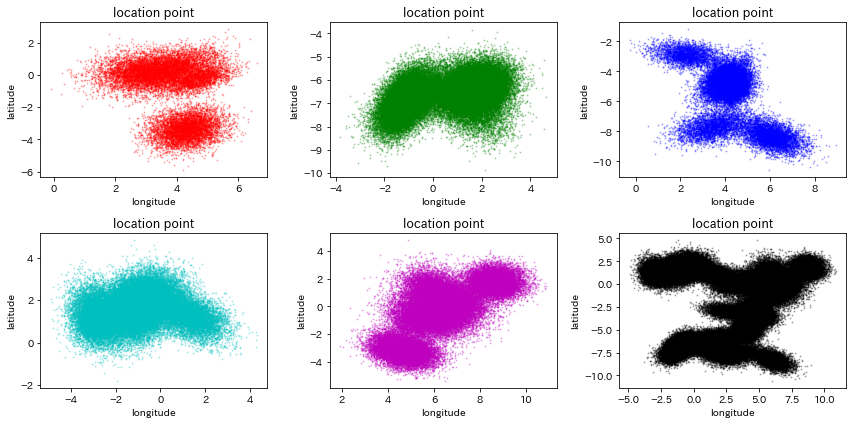

In [6]:
#locatio分布を可視化
colorlist = ["r", "g", "b", "c", "m", "y", "k", "w"]
fig = plt.figure(figsize=(12.0, 6.0))
for j in range(k1):
    index = index_r1[j]
    ax = fig.add_subplot(2, 3, j+1)
    ax.scatter(y[index, 0], y[index, 1], s=1, c=colorlist[j], alpha=0.25, linewidths="1", edgecolors=colorlist[j])
    plt.title("location point", fontsize=12.5)
    plt.xlabel("longitude")
    plt.ylabel("latitude")
ax = fig.add_subplot(2, 3, k1+1)
ax.scatter(y[:, 0], y[:, 1], s=1, c=colorlist[k1+1], alpha=0.25, linewidths="1", edgecolors=colorlist[k1+1])
plt.title("location point", fontsize=12.5)
plt.xlabel("longitude")
plt.ylabel("latitude")
fig.tight_layout()
plt.show()

In [7]:
#単語のインデックスを作成
wd_list = [i for i in range(v)]
wd_vec = [i for i in range(v)]
word_freq = np.repeat(0, v)
for i in range(v):
    wd_list[i] = np.array(np.where(wd==i)[0], dtype="int")
    wd_vec[i] = np.repeat(1, wd_list[i].shape[0])
    word_freq[i] = wd_list[i].shape[0]

# 3. User Tracking and Document model
## a. モデル概要
nested Chinese Restaulant Franchiseを用いて、統計モデルの実装を行います。
モデルとして、ユーザーが訪れた場所とそこで行ったtweetの同時分布のトピックモデルを考えます。つまりユーザーが訪れた場所によってtweetの内容が変化すると仮定したモデルになります。  
例えば、場所を階層構造に拡張することでいえば、東京を親ノードとした場合、その子ノードに渋谷、新宿などの地域をさらにこの子ノードを親として、例えば渋谷なら代々木や原宿や渋谷周辺などというような子ノードを生成することで階層構造の場所分布を自動的に抽出することが可能になります。  
tweetは生成されたノードそれぞれで固有のトピック分布を持つことで場所ごとにどのようなトピックの単語が現れやすいかを解析することができます。  
  
nested Chinese Restaulant Franchiseの仮定に基づき、ユーザーごとにノード構造が異なると仮定しますが、ユーザー全体では同じノード構造を共有しています。さらにそれぞれのノードには場所とtweetのトピック分布に対する異なるパラメータを持っており、これらのパラメータは親ノードのパラメータを共有することで子ノード同士が相関を持つ構造になっています。  
つまり、globalなノード分布が$G_{0} \sim DP(\alpha, H)$から生成され、ユーザーごとのlocalなノード分布が$G_{u} \sim DP(\beta, G_{0})$から生成されるイメージです。

![title](https://yahoo.jp/box/-P_grR)


参考にした論文は以下のurlにあります。  
http://proceedings.mlr.press/v28/ahmed13.pdf

## b. 生成過程
上記で議論したモデルの生成過程は以下の通りです。
#### 生成過程
- For each tweet $d$ written by user $u$
    - (a) Sample a node $r_{d} \sim nCRF(\alpha, \beta, u)$ 
    - (b) If node $r_{d}$ is a globally new node theta
        - ⅰ. $\mu_{r_{d}} \sim N(\mu_{\pi(r_{d})}, \Sigma_{\pi(r_{d})})$
        - ⅱ. $\phi_{r_{d}} \sim Dirichlet(\omega\phi_{\pi(r_{d})})$
        - ⅲ. $\theta_{r_{d}} \sim Dirichlet(\lambda\theta_{\pi(r_{d})})$
    - (c) Sample a location $l_{d} \sim N(\mu_{r_{d}}, \Sigma_{r_{d}})$
    - (d) For each word $w_{d, i}$
        - ⅰ. Sample a topic $z_{d, i} \sim Categorical(\theta_{r_{d}})$
        - ⅱ. Sample a word $w_{d, i} \sim Categorical(\phi_{z_{d, i}})$ 
          
なお生成過程中に現れる$\pi(*)$は親ノードの分布を表しています。

In [8]:
####マルコフ連鎖モンテカルロ法でパラメータを推定####
##多変量正規分布の密度関数
def dmv(x, mu, Cov, k):
    er = x - mu
    Cov_inv = np.linalg.inv(Cov) 
    LLo = 1 / (np.sqrt(pow((2 * np.pi), k) * np.linalg.det(Cov))) * np.exp(-1/2 * np.dot(np.dot(er, Cov_inv) *er, np.ones(k)))
    return(LLo)

##アルゴリズムの設定
max_k1 = 7
R = 2000
keep = 2
burnin = int(500/keep)
iter = 0
disp = 10
target_iter = 50
sample_rate = np.repeat(1/N, N)

In [9]:
##事前分布の設定
#nCRFの集中度パラメータ
alpha1 = 0.1; beta1 = 0.1
alpha2 = 0.1; beta2 = 0.25

#モデルパラメータの事前分布
Deltabar = np.repeat(0.0, geo)
ADelta = 0.01
nu = geo + 1
V = nu * np.diag(np.ones(geo))
pi1 = 0.25
pi2 = 0.1
pi3 = 0.01

#パラメータサンプリング時の誤差
delta0 = np.repeat(0.0, geo)
tau0 = np.diag(np.repeat(0.5, geo))
omega0 = 2.5
er0 = 0.05

In [10]:
##パラメータの真値
#ノード構造の真値
levels = 2
k1 = 5
k2 = np.array([4, 4, 5, 5, 6])

#潜在変数の真値
Ri1 = np.array(R1.copy(), dtype="int")
r1 = np.dot(Ri1, np.arange(k1))
Ri2 = np.array(R2.copy(), dtype="int")
r2 = np.dot(Ri2, np.arange(np.max(k2)))
r = np.hstack((r1[:, np.newaxis], r2[:, np.newaxis]))
Zi = Z.copy()
z = np.dot(Zi, np.arange(topic))

#モデルパラメータの真値
G1 = GT1.copy(); G2 = GT2.copy()
theta1 = thetat1.copy(); theta2 = thetat2.copy()
gamma_global = gammat_global.copy()
gamma = gammat.copy()
mu = mut.copy(); Cov = Covt.copy()
phi = phit.copy()

#location分布の真値
mu_global = mut_global.copy()
Cov_global = np.zeros((geo, geo, k1))
for j in range(k1):
    index = np.array(np.where(Ri1[:, j]==0)[0], dtype="int")
    er = y[index, ] - mu_global[j, ]
    Cov_global[:, :, j] = np.dot(er.T, er) / index.shape[0]

In [11]:
##初期値の設定
#ノード構造の初期値
levels = 2
k1 = 3
k2 = np.repeat(1, k1)

#モデルパラメータの初期値
alpha01 = 2.0; alpha02 = 2.5
G1 = np.random.dirichlet(np.repeat(5.0, k1), 1).reshape(-1)
G2 = [np.random.dirichlet(np.repeat(5.0, k2[j]), 1).reshape(-1)  for j in range(k1)]
GT1 = G1.copy(); GT2 = G2.copy()
theta1 = np.random.dirichlet(alpha01*G1, hh)
theta2 = [np.random.dirichlet(alpha01*G2[j], hh) for j in range(k1)]
gamma_global = np.random.dirichlet(np.repeat(5.0, topic), k1)
gamma = [gamma_global[j, ] for j in range(k1)]
mu_global = np.zeros((k1, geo))
Cov_global = np.zeros((geo, geo, k1))
for j in range(k1):
    mu_global[j, ] = np.random.multivariate_normal(np.mean(y, axis=0), np.diag(np.repeat(25.0, geo)), 1)
    Cov_global[:, :, j] = np.diag(np.repeat(0.25, geo))
mu = [mu_global[j, ] for j in range(k1)]
Cov = [Cov_global[:, :, np.array([j])] for j in range(k1)]
phi = np.random.dirichlet(np.repeat(5.0, v), topic)

#潜在ノードの初期値
Ri1 = np.array(rmnom(theta1[u_id, ], N, k1, 1)[1], dtype="int8")
r1 = np.dot(Ri1, np.arange(k1))
Ri2 = np.zeros((N, np.max(k2)), dtype="int8")
r2 = np.repeat(0, N)
index_r1 = [j for j in range(k1)]
for j in range(k1):
    index = np.array(np.where(Ri1[:, j]==1)[0], dtype="int")
    n = index.shape[0]
    Ri2[index, :k2[j]] = np.array(rmnom(theta2[j][u_id[index], ], n, k2[j], 1)[1], dtype="int8")
    r2[index] = np.dot(R2[index, :k2[j]], np.arange(k2[j]))

#トピックの初期値
out = rmnom(np.full((f, topic), 1/topic), f, topic, 1)
Zi = np.array(out[1], dtype="int8")
z_vec = np.array(out[0], dtype="int16")

old_setting = np.seterr(divide='raise', invalid='raise')

In [12]:
##nCRFのグローバルノードとローカルノードの頻度を定義
#パラメータの格納用配列
M1 = np.sum(Ri1, axis=0)
M2 = [i for i in range(k1)]
m1 = np.zeros((hh, k1), dtype="int")
m2 = [np.zeros((hh, k2[i]), dtype="int") for i in range(k1)]

#グローバルノードの頻度
freq = np.dot(Ri2.T, Ri1).T
for j in range(k1):
    M2[j] = freq[j, ][:k2[j]]
    
#ローカルノードの頻度
for i in range(hh):
    index = u_list[i]
    m1[i, ] = np.sum(Ri1[index, ], axis=0)
    freq = np.dot(Ri2[index, ].T, Ri1[index, ]).T
    for j in range(k1):
        m2[j][i, ] = freq[j, ][:k2[j]]
        
#階層的事前分布を定義
Prior1 = m1/(pt_vec+alpha1) + alpha1/(pt_vec+alpha1)*M1/(N+beta1); Prior1 = np.hstack((Prior1, 1-np.sum(Prior1, axis=1)[:, np.newaxis]))
Prior2 = [j for j in range(k1)]
for j in range(k1):
    freq = np.sum(m2[j], axis=1)[:, np.newaxis]
    Prior2[j] = m2[j]/(freq+alpha2) + alpha2/(freq+alpha2)*M2[j]/(np.sum(M2[j])+beta2)
    Prior2[j] = np.hstack((Prior2[j], 1-np.sum(Prior2[j], axis=1)[:, np.newaxis]))
    
#文書ごとのトピック頻度を数える
z_freq = np.zeros((N, topic), dtype="int")
for i in range(N):
    z_freq[i, ] = np.dot(Zi[d_list[i], ].T, d_vec[i])

In [13]:
##パラメータの格納用配列
#モデルパラメータの格納用配列
MU1 = [j for j in range(int(R/keep))]
MU2 = [j for j in range(int(R/keep))]
COV1 = [j for j in range(int(R/keep))]
COV2 = [j for j in range(int(R/keep))]
GAMMA1 = [j for j in range(int(R/keep))]
GAMMA2 = [j for j in range(int(R/keep))]
PHI = np.zeros((topic, v, int(R/keep)))

#潜在変数の格納用配列
SEG1 = np.zeros((N, int(R/keep)), dtype="int8")
SEG2 = np.zeros((N, int(R/keep)), dtype="int")
TOPIC = np.zeros((f, topic), dtype="int")

In [14]:
##学習データの真値の対数尤度
#ノード構造の真値
levels0 = 2
k01 = 5
k02 = np.array([4, 4, 5, 5, 6])

#locationの対数尤度
LL01 = 0
for i in range(k01):
    index = np.array(np.where(R1[:, i])[0], dtype="int")
    Lho_dmv = np.zeros((index.shape[0], k02[i]))
    for j in range(k02[i]):
        Lho_dmv[:, j] = dmv(y[index, ], mut[i][j, ], Covt[i][:, :, j], geo)
    LL01 += np.sum(np.log(np.sum(thetat2[i][u_id[index], ] * Lho_dmv, axis=1)))
print(LL01)

#トピックモデルの対数尤度
R_vec01 = R1[d_id, ]; R_vec02 = R2[d_id, ]
r_vec02 = np.dot(R_vec02, np.arange(np.max(k02)))
Lho_topic = np.zeros((f, topic))
for j in range(k01):
    index = np.array(np.where(R_vec01[:, j]==1)[0], dtype="int")
    Lho_topic[index, ] = gammat[j][r_vec02[index], ] * (phit.T)[wd[index], ]
LL02 = np.sum(np.log(np.sum(Lho_topic, axis=1)))
print(LL02)

#対数尤度の和
LL0 = LL01 + LL02
print(LL0)

-508354.4498122048
-18420596.943053193
-18928951.392865397


In [15]:
####ギブスサンプリングでパラメータをサンプリング####
for rp in range(R):
    
    ##level1のノードをサンプリング
    #新しいパラメータをサンプリング
    if k1 <= max_k1:
        k_level1 = k1 + 1
        target = np.argmax(np.random.multinomial(1, sample_rate, 1))
        mu_new = np.vstack((mu_global, y[target, ] + np.random.multivariate_normal(delta0, tau0, 1)))
        Cov_new = np.zeros((geo, geo, k1+1))
        Cov_new[:, :, :k1] = Cov_global; Cov_new[:, :, k1] = np.diag(np.repeat(0.5, geo))
        gamma0 = np.sum(Zi[d_list[target], ], axis=0) / w[target]
        gamma_new = np.vstack((gamma_global, np.random.dirichlet(omega0*gamma0 + er0, 1)))
    else:
        k_level1 = mu_global.shape[0]
        mu_new = mu_global.copy()
        Cov_new = Cov_global.copy()
        gamma_new = gamma_global.copy()

    #同時分布の尤度を定義
    Lho11 = np.zeros((N, k_level1))
    for i in range(k_level1):
        Lho11[:, i] = dmv(y, mu_new[i, ], Cov_new[:, :, i], geo)
    Lho11[np.isnan(Lho11)] = 0
    Lho12 = np.exp(np.dot(z_freq, np.log(gamma_new).T))
    Lho1 = Prior1[u_id, ] * Lho11 * Lho12
    
    #多項分布からノードをサンプリング
    Prob1 = Lho1 / np.sum(Lho1, axis=1)[:, np.newaxis]
    out1 = rmnom(Prob1, N, k_level1, 1)
    Ri1 = np.array(out1[1], dtype="int")
    
    #出現があるノードのみ採択
    index_k1 = np.array(np.where(np.sum(Ri1, axis=0) > 0)[0], dtype="int")
    Ri1 = Ri1[:, index_k1]
    r1 = np.dot(Ri1, np.arange(index_k1.shape[0]))
    if index_k1.shape[0] > k1:
        k2 = np.append(k2, 1)
    k1 = index_k1.shape[0]
    
        
    ##nCRFのグローバルノードとローカルノードの頻度を定義
    #パラメータの格納用配列
    M1 = np.sum(Ri1, axis=0)
    M2 = [i for i in range(k1)]
    m1 = np.zeros((hh, k1), dtype="int")
    m2 = [np.zeros((hh, k2[i]), dtype="int") for i in range(k1)]
    index_r1 = [i for i in range(k1)]
    n = np.repeat(0, k1)

    #グローバルノードの頻度
    freq = np.dot(Ri2.T, Ri1).T
    for j in range(k1):
        index_r1[j] = np.array(np.where(Ri1[:, j]==1)[0], dtype="int")
        n[j] = index_r1[j].shape[0]
        M2[j] = freq[j, ][:k2[j]]

    #ローカルノードの頻度
    for i in range(hh):
        index = u_list[i]
        m1[i, ] = np.sum(Ri1[index, ], axis=0)
        freq = np.dot(Ri2[index, ].T, Ri1[index, ]).T
        for j in range(k1):
            m2[j][i, ] = freq[j, ][:k2[j]]

    #階層的事前分布を定義
    alpha11 = alpha1/k1; beta11 = beta1/k1
    alpha21 = M1/N * alpha2; beta21 = M1/N * beta2
    Prior1 = m1/(pt_vec+alpha11) + alpha11/(pt_vec+alpha11)*M1/(N+beta11)
    if k1 <= max_k1:
        Prior1 = np.hstack((Prior1, 1-np.sum(Prior1, axis=1)[:, np.newaxis]))
    Prior2 = [j for j in range(k1)]
    for j in range(k1):
        freq = np.sum(m2[j], axis=1)[:, np.newaxis]
        Prior2[j] = m2[j]/(freq+alpha21[j]) + alpha21[j]/(freq+alpha21[j])*M2[j]/(np.sum(M2[j])+beta21[j])
        Prior2[j] = np.hstack((Prior2[j], 1-np.sum(Prior2[j], axis=1)[:, np.newaxis]))


    ##Level1のパラメータをサンプリング
    #新しいモデルパラメータ
    if k1 > mu_global.shape[0]:
        flag = 1
    else:
        flag = 0

    #ノードごとにパラメータを更新
    for j in range(k1):
        #多変量正規分布から期待値をサンプリング
        index = index_r1[j]
        y_target = y[index, ] 
        mu_par = np.sum(y_target, axis=0) / (n[j] + ADelta)
        Sigma = np.kron(Cov_new[:, :, j], 1/n[j])
        mu_new[j, ] = np.random.multivariate_normal(mu_par, Sigma, 1)

        #逆ウィシャート分布から分散共分散行列をサンプリング
        er = y_target - mu_new[j, ]
        IW_R = np.dot(er.T, er) + V
        Sn = n[j] + nu
        Cov_new[:, :, j] = scipy.stats.invwishart.rvs(Sn, IW_R, 1)

        #ディリクレ分布からトピック分布をサンプリング
        wsum = np.sum(z_freq[index, ], axis=0) + pi1
        gamma_new[j, ] = np.random.dirichlet(wsum, 1)

    #パラメータをコピー
    index_target = np.arange(k1)
    mu_global = mu_new[index_target, ]
    Cov_global = Cov_new[:, :, index_target]
    gamma_global = gamma_new[index_target, ]


    ##Level2のノードをサンプリング
    #新しいパラメータの設定とパラメータの格納用配列を定義
    if flag==1:
        mu.append(mu_global[np.array([k1-1]), ])
        Cov.append(Cov_global[:, :, k1-1].reshape(geo, geo, 1))
        gamma.append(gamma_global[np.array([k1-1]), ])
    Ri2 = np.zeros((N, np.max(k2)+1), dtype="int")
    r2 = np.repeat(0, N)


    ##Level2のノードをサンプリング
    #パラメータの格納用配列
    Lho_dmv = np.zeros((N, np.max(k2)))
    Ri2 = np.zeros((N, np.max(k2)+1), dtype="int")

    #新しいパラメータをサンプリング
    for i in range(k1):
        index = index_r1[i]
        target = index[np.argmax(np.random.multinomial(1, np.repeat(1/n[i], n[i]), 1))]
        mu_new = np.vstack((mu[i], y[target, ] + np.random.multivariate_normal(delta0, tau0, 1)))
        Cov_new = np.zeros((geo, geo, k2[i]+1))
        Cov_new[:, :, :k2[i]] = Cov[i]; Cov_new[:, :, k2[i]] = np.diag(np.repeat(0.5, geo))
        gamma0 = np.sum(Zi[d_list[target], ], axis=0) / w[target]
        gamma_new = np.vstack((gamma[i], np.random.dirichlet(gamma0 + er0, 1)))

        #同時分布の尤度を定義
        Lho21 = np.zeros((n[i], k2[i]+1))
        for j in range(k2[i]+1):
            Lho21[:, j] = dmv(y[index, ], mu_new[j, ], Cov_new[:, :, j], geo)
        Lho21[np.isnan(Lho21)] = 0
        Lho22 = np.exp(np.dot(z_freq[index, ], np.log(gamma_new).T))
        Lho2 = Prior2[i][u_id[index], ] * Lho21 * Lho22

        #多項分布からノードをサンプリング
        Prob2 = Lho2 / np.sum(Lho2, axis=1)[:, np.newaxis]
        out2 = rmnom(Prob2, n[i], k2[i]+1, 1)
        Nord2 = np.array(out2[1], dtype="int")
        
        #出現があるノードのみ採択
        index_k2 = np.array(np.where(np.sum(Nord2, axis=0) > 0)[0], dtype="int")
        k2[i] = index_k2.shape[0]
        Ri2[index, :k2[i]] = Nord2[:, index_k2]
        mu[i] = mu_new[index_k2, ]
        Cov[i] = Cov_new[:, :, index_k2]
        gamma[i] = gamma_new[index_k2, ]
        

    #ローカルノードの頻度を更新
    k2 = k2[np.arange(k1)]
    Ri2 = Ri2[:, np.arange(np.max(k2))]
    r2 = np.dot(Ri2, np.arange(np.max(k2)))
    freq = np.dot(Ri2.T, Ri1).T
    for j in range(k1):
        M2[j] = freq[j, ][:k2[j]]


    ##ノードごとにlocation分布のパラメータをサンプリング
    #多変量正規分布から期待値をサンプリング
    for i in range(k1):
        index = index_r1[i]
        for j in range(k2[i]):
            y_target = y[index, ] * Ri2[index, j][:, np.newaxis]
            mu_par = np.sum(y_target, axis=0) / (M2[i][j] + ADelta)
            Sigma = np.kron(Cov[i][:, :, j], 1/M2[i][j])
            mu[i][j, ] = np.random.multivariate_normal(mu_par, Sigma, 1)

            #逆ウィシャート分布から分散共分散行列をサンプリング
            er = y_target - mu[i][j, ]*Ri2[index, j][:, np.newaxis]
            IW_R = np.dot(er.T, er) + V
            Sn = M2[i][j, ] + nu
            Cov[i][:, :, j] = scipy.stats.invwishart.rvs(Sn, IW_R, 1)


    ##ノードごとにトピックをサンプリング
    #ノード割当を単語idに割り当てる
    R_vec1 = Ri1[d_id, ]; R_vec2 = Ri2[d_id, ]
    r_vec2 = np.dot(R_vec2, np.arange(np.max(k2)))

    #トピックの割当確率を定義
    Lho_topic = np.zeros((f, topic))
    index_r2 = [j for j in range(k1)]
    for j in range(k1):
        index_r2[j] = np.array(np.where(R_vec1[:, j]==1)[0], dtype="int")
        Lho_topic[index_r2[j], ] = gamma[j][r_vec2[index_r2[j]], ] * (phi.T)[wd[index_r2[j]], ]
    Prob = Lho_topic / np.sum(Lho_topic, axis=1)[:, np.newaxis]

    #多項分布からトピックをサンプリング
    out = rmnom(Prob, f, topic, 1)
    Zi = np.array(out[1], dtype="int")
    z = np.array(out[0], dtype="int")
    
    #文書ごとのトピック頻度を数える
    z_freq = np.zeros((N, topic), dtype="int")
    for i in range(N):
        z_freq[i, ] = np.dot(Zi[d_list[i], ].T, d_vec[i])


    ##トピックモデルのパラメータをサンプリング
    #トピック分布をサンプリング
    for i in range(k1):
        wsum = np.dot(Zi.T, R_vec2[:, :k2[i]] * R_vec1[:, i][:, np.newaxis]).T + pi2
        for j in range(k2[i]):
            gamma[i][j, ] = np.random.dirichlet(wsum[j, ], 1).reshape(-1)

    #単語分布をサンプリング
    vsum = np.zeros((topic, v))
    for j in range(v):
        vsum[:, j] = np.dot(Zi[wd_list[j], ].T, wd_vec[j])
    for j in range(topic):
        phi[j, ] = np.random.dirichlet(vsum[j, ] + pi3, 1).reshape(-1)


    ##サンプリング結果の格納と表示
    #サンプリング結果の格納
    if rp%keep==0:
        mkeep = int(rp/keep)
        MU1[mkeep] = mu_global
        MU2[mkeep] = mu
        COV1[mkeep] = Cov_global
        COV2[mkeep] = Cov
        GAMMA1[mkeep] = gamma_global
        GAMMA2[mkeep] = gamma
        PHI[:, :, mkeep] = phi
        SEG1[:, mkeep] = r1
        SEG2[:, mkeep] = r2
        
    #トピック割当はバーンイン期間を超えたら格納
    if rp%keep==0 & rp >= burnin:
        TOPIC = TOPIC + Zi

    if rp%disp==0:
        #学習データの対数尤度
        Lho_dmv = np.zeros((N, np.max(k2)))
        for i in range(k1):
            index = index_r1[i]
            for j in range(k2[i]):
                Lho_dmv[index, j] = Prior2[i][u_id[index], j] * dmv(y[index, ], mu[i][j, ], Cov[i][:, :, j], geo)
        LL1 = np.sum(np.log(np.sum(Lho_dmv[np.sum(Lho_dmv, axis=1) > 0, ], axis=1)))
        LL2 = np.sum(np.log(np.sum(Lho_topic, axis=1)))
        LL = LL1 + LL2

        #サンプリング結果の表示
        print(rp)
        print(k1)
        print(k2)
        print(M1)
        print(np.round([LL1, LL2, LL, LL01, LL02, LL0], 1))

0
4
[2 2 2 1]
[133494  40713  24382    675]
[  -798326.6 -27508423.9 -28306750.5   -508354.4 -18420596.9 -18928951.4]
10
4
[2 2 2 1]
[112527  45297  38860   2580]
[  -759218.4 -20948710.6 -21707928.9   -508354.4 -18420596.9 -18928951.4]
20
4
[2 2 2 1]
[110834  45293  39040   4097]
[  -753021.  -20905520.4 -21658541.4   -508354.4 -18420596.9 -18928951.4]
30
4
[2 2 2 1]
[110614  45293  39089   4268]
[  -751919.9 -20889703.3 -21641623.2   -508354.4 -18420596.9 -18928951.4]
40
4
[2 2 2 1]
[110571  45292  39091   4310]
[  -751767.4 -20880676.6 -21632443.9   -508354.4 -18420596.9 -18928951.4]
50
4
[2 2 2 1]
[110543  45294  39097   4330]
[  -751642.2 -20877354.  -21628996.1   -508354.4 -18420596.9 -18928951.4]
60
4
[2 2 2 1]
[110523  45293  39089   4359]
[  -751553.3 -20875683.4 -21627236.7   -508354.4 -18420596.9 -18928951.4]
70
4
[2 2 2 1]
[110505  45293  39086   4380]
[  -751494.6 -20874572.7 -21626067.3   -508354.4 -18420596.9 -18928951.4]
80
4
[2 2 2 1]
[110492  45292  39075   4405]
[  -

600
8
[3 5 4 9 4 7 3 3]
[30103 45208 20598 23413 15335 28902 25254 10451]
[  -462313.9 -18610944.4 -19073258.3   -508354.4 -18420596.9 -18928951.4]
610
8
[3 5 4 9 4 7 3 3]
[30082 45205 20630 23401 15335 28931 25226 10454]
[  -462199.2 -18608943.4 -19071142.7   -508354.4 -18420596.9 -18928951.4]
620
8
[3 5 4 9 4 7 3 3]
[30081 45204 20650 23382 15335 28932 25226 10454]
[  -462200.  -18607614.7 -19069814.7   -508354.4 -18420596.9 -18928951.4]
630
8
[3 5 4 9 4 7 3 3]
[30062 45205 20681 23424 15335 28939 25165 10453]
[  -462353.5 -18606769.4 -19069122.9   -508354.4 -18420596.9 -18928951.4]
640
8
[3 5 4 9 4 7 3 3]
[30065 45204 20645 23439 15336 28942 25177 10456]
[  -462237.4 -18605450.8 -19067688.2   -508354.4 -18420596.9 -18928951.4]
650
8
[3 5 4 9 4 7 3 3]
[30082 45203 20692 23473 15333 28925 25097 10459]
[  -462196.8 -18604094.2 -19066291.    -508354.4 -18420596.9 -18928951.4]
660
8
[3 5 4 9 4 7 3 3]
[30131 45203 20671 23453 15333 28877 25136 10460]
[  -462133.2 -18603788.9 -19065922.1  

1160
8
[2 5 6 9 4 6 2 3]
[29996 45204 20871 26267 15330 29023 22079 10494]
[  -462484.7 -18554464.7 -19016949.4   -508354.4 -18420596.9 -18928951.4]
1170
8
[2 5 6 8 4 6 2 3]
[30031 45203 20881 26278 15330 28991 22066 10484]
[  -462472.2 -18553789.6 -19016261.8   -508354.4 -18420596.9 -18928951.4]
1180
8
[2 5 6 8 4 6 2 3]
[30036 45202 20863 26287 15329 28983 22075 10489]
[  -462485.8 -18553355.7 -19015841.5   -508354.4 -18420596.9 -18928951.4]
1190
8
[2 5 6 8 4 6 2 3]
[29992 45203 20857 26271 15329 29032 22095 10485]
[  -462598.4 -18551531.  -19014129.4   -508354.4 -18420596.9 -18928951.4]
1200
8
[2 5 6 8 4 6 2 3]
[30011 45203 20840 26292 15329 29012 22091 10486]
[  -462423.6 -18547092.2 -19009515.8   -508354.4 -18420596.9 -18928951.4]
1210
8
[2 5 6 9 4 6 2 3]
[29996 45202 20853 26296 15330 29025 22075 10487]
[  -462469.7 -18546755.1 -19009224.8   -508354.4 -18420596.9 -18928951.4]
1220
8
[2 5 6 7 4 6 2 3]
[29964 45202 20863 26291 15330 29055 22077 10482]
[  -462593.4 -18546674.1 -19009

1710
8
[2 5 5 7 4 6 2 1]
[29969 45203 20908 26306 15330 29042 22020 10486]
[  -462900.7 -18543547.9 -19006448.6   -508354.4 -18420596.9 -18928951.4]
1720
8
[2 5 5 7 4 6 2 1]
[29975 45203 20890 26302 15330 29036 22031 10497]
[  -462908.3 -18543596.9 -19006505.2   -508354.4 -18420596.9 -18928951.4]
1730
8
[2 5 5 8 4 6 2 1]
[29989 45203 20881 26304 15329 29024 22039 10495]
[  -462713.7 -18543425.  -19006138.7   -508354.4 -18420596.9 -18928951.4]
1740
8
[2 5 5 7 4 6 2 1]
[30005 45204 20886 26300 15329 29006 22040 10494]
[  -462841.7 -18543562.6 -19006404.4   -508354.4 -18420596.9 -18928951.4]
1750
8
[2 6 5 7 4 6 2 1]
[30010 45204 20903 26289 15330 29001 22039 10488]
[  -462893.  -18543591.2 -19006484.3   -508354.4 -18420596.9 -18928951.4]
1760
8
[2 5 5 8 4 6 2 1]
[30015 45205 20908 26293 15329 28998 22028 10488]
[  -462786.8 -18543410.9 -19006197.7   -508354.4 -18420596.9 -18928951.4]
1770
8
[2 5 5 8 4 6 3 1]
[29975 45203 20900 26285 15330 29040 22038 10493]
[  -462794.6 -18543271.8 -19006